<a href="https://colab.research.google.com/github/RubenLewis003/Pricing-and-hedging-VIX-options/blob/main/FM50FinancialMathsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mosek
%pip install cvxpy[MOSEK]
import cvxpy as cp

from google.colab import files
uploaded = files.upload()
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 84.3 MB/s eta 0:00:00


Saving mosek.lic to mosek.lic


In [ ]:
os.makedirs('/root/mosek', exist_ok=True)
!mv mosek.lic /root/mosek/mosek.lic

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from jax import grad

plt.style.use('ggplot')



np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)

## Task 1

ADF Statistic: -6.1636658575163485
p-value: 7.074382187560424e-08
Critical Values: {'1%': np.float64(-3.431094843138197), '5%': np.float64(-2.8618691713324633), '10%': np.float64(-2.566945212919472)}


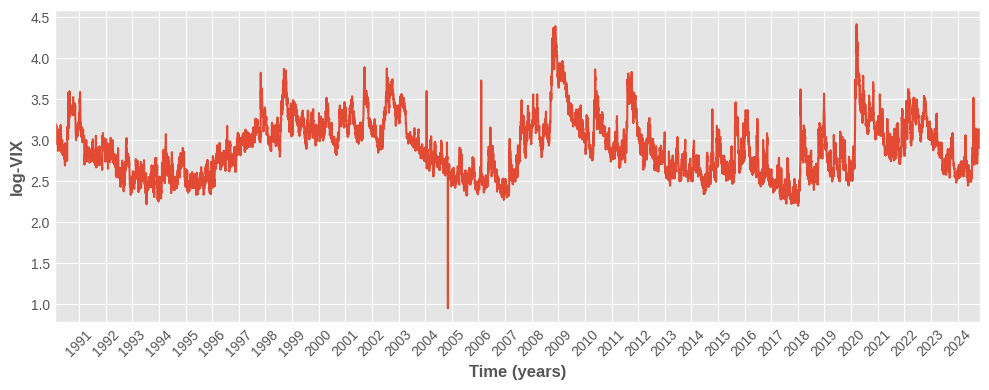

<Figure size 800x400 with 0 Axes>

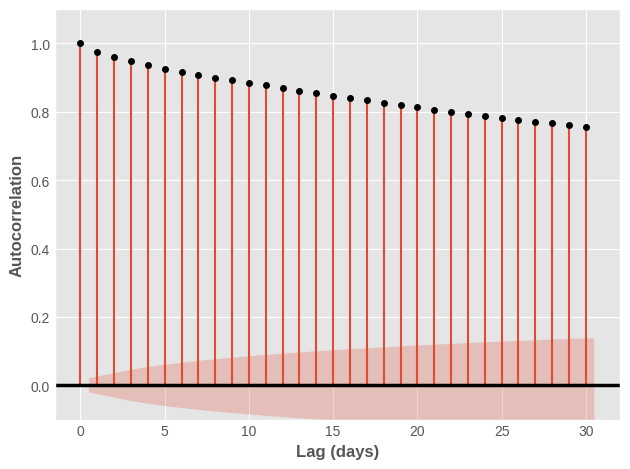

<Figure size 800x400 with 0 Axes>

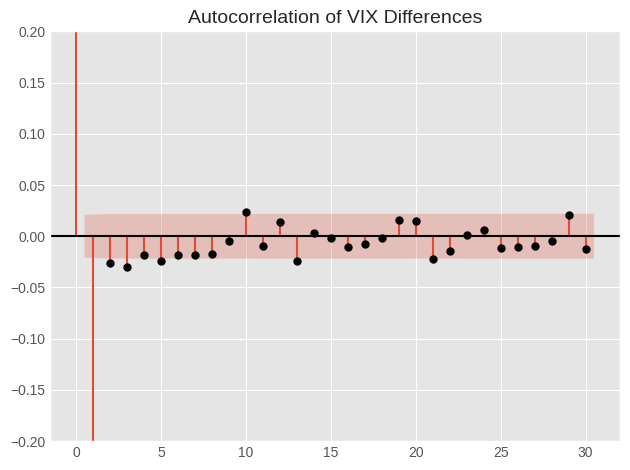

In [ ]:
#VIX data analysis

VIXopeningprices = pd.read_csv('VIX-daily-opening-prices.csv')
X = VIXopeningprices.iloc[:,0]

logVIX = np.log(VIXopeningprices.iloc[:,1])
logVIXshifted = logVIX.shift(-1)
logVIXdifferences = np.diff(logVIX)

result = adfuller(logVIX)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', np.array(result[4]))

X_dates = pd.to_datetime(X)
plt.figure(figsize=(10, 4))
plt.plot(X_dates, logVIX, linewidth=1.5)
plt.xlim(pd.Timestamp('1990-02-01'), pd.Timestamp('2024-11-04'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Time (years)', fontsize=12, fontweight='bold')
plt.ylabel('log-VIX', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plot_acf(np.array(logVIX), lags=30, color='black', linewidth=2.5, markersize=4, title='')
plt.xlabel('Lag (days)', fontsize=12, fontweight='bold')
plt.ylabel('Autocorrelation', fontsize=12, fontweight='bold')
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plot_acf(np.array(logVIXdifferences), lags=30, color='black')
plt.ylim(-0.2, 0.2)
plt.title('Autocorrelation of VIX Differences', fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
#Model 1 - Simple linear least squares regression
# Linear y = m*x + b
# Matrix d = G @ m
#Therefore

G = np.stack((logVIX[:-1],np.ones(logVIX[:-1].shape)),axis=1)
d = logVIXshifted[:-1]

print(f'Daily Time Series:')

print(G.shape)
print(d.shape)

m, RSS, rank, s = np.linalg.lstsq(G, d)
print(m.T)

print(f'Coefffieients: {m}')
print(f'Residual sum of squares: {RSS}')
print(f'MSE = {RSS/len(d)}')
print(f'rank: {rank}')
print(f'Singular values: {s}')
print('||')
#19day interval

G18 = np.stack((logVIX18day[:-1],np.ones(logVIX18dayshifted[:-1].shape)),axis=1)
d18 = logVIX18dayshifted[:-1]

print(f'18 Day Interval Time Series:')

print(G18.shape)
print(d18.shape)

m18, RSS18, rank18, s18 = np.linalg.lstsq(G18, d18)

print(f'Coefffieients: {m18}')
print(f'Residual sum of squares: {RSS18}')
print(f'MSE = {RSS18/len(d18)}')
print(f'rank: {rank18}')
print(f'Singular values: {s18}')

Daily Time Series:
(8791, 2)
(8791,)
[0.9755  0.07129]
Coefffieients: [0.9755  0.07129]
Residual sum of squares: [51.56156]
MSE = [0.00587]
rank: 2
Singular values: [290.05094  10.54728]
||
18 Day Interval Time Series:
(488, 2)
(488,)
Coefffieients: [0.84449 0.45302]
Residual sum of squares: [16.1763]
MSE = [0.03315]
rank: 2
Singular values: [68.38661  2.42613]


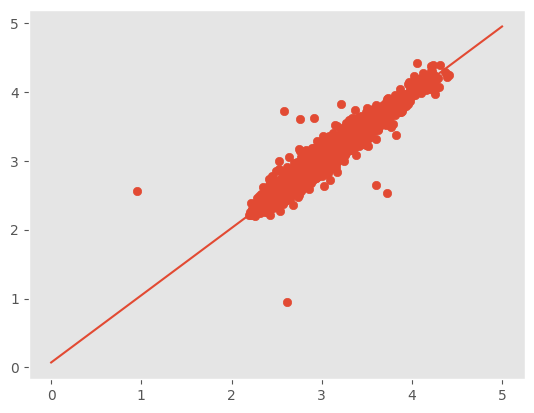

(50, 2)
(50,)


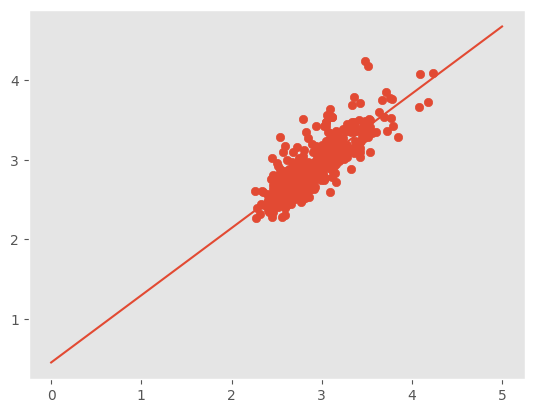

In [ ]:

#daily interval

xpred = np.linspace(0,5)
gpred = np.stack((xpred,np.ones(xpred.shape)), axis=1)
ypred = gpred @ m

plt.scatter(logVIX[:-1],logVIXshifted[:-1])
plt.plot(xpred,ypred)
plt.grid()
plt.show()

#19 day interval

xpred18 = np.linspace(0,5)
gpred18 = np.stack((xpred18,np.ones(xpred18.shape)), axis=1)
ypred18 = gpred18 @ m18

print(gpred18.shape)
print(ypred18.shape)

plt.scatter(logVIX18day[:-1],logVIX18dayshifted[:-1])
plt.plot(xpred18,ypred18)
plt.grid()
plt.show()

0.07129267088994518 0.9755016824095398


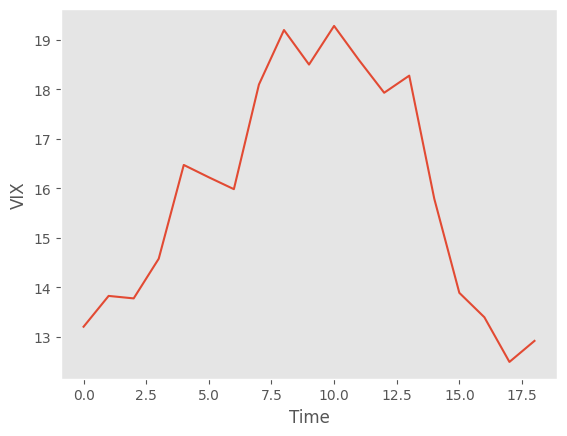

2.7019180910404392
Daily time intervals:
The speed of mean reversion a=0.024498317590460172
The mean-reversion level 2.910104770529511
The volatility of the process is 0.07659374420551314
The 18-day volatility of the process is 0.324959735545117
The recorded volatility is: 0.2682043577696507
The condition number is: 27.500057823388012
The half-life of volatility shocks = 27.945658299325558
||
18 day time intervals:
The speed of mean reversion a=0.1555057497894493
The mean-reversion level 2.913221987929683
The volatility of the process is 0.1875256343594055
The recorded volatility is: 0.2682043577696507
The condition number is: 28.18750790016459
The half-life of volatility shocks = 28.707290863574876


In [ ]:

beta = m[0]
alpha = m[1]
print(alpha, beta)

vol = np.sqrt((RSS)/(8791-2)).item()

a = 1 - beta
Vmean = alpha/a


def OU_prediction(V0, timesteps,Vmean,vol,a,paths):
  dt = 1
  V = np.zeros((paths, timesteps+1))
  V[:,0] = V0
  np.random.seed(42)
  DW = np.random.normal(0,1, size=(paths,timesteps))
  for i in range(timesteps):
    V[:,i+1] = V[:,i] - a*(V[:,i] - Vmean)*dt + vol*np.sqrt(dt)*DW[:,i]
  return V

predicted_logV = OU_prediction(np.log(13.2), 18, Vmean, vol, a, 10000)
newvol = predicted_logV[:,-1].std()

X = np.linspace(0, 18, 19)
plt.plot(X, np.exp(predicted_logV[0,:]))
plt.xlabel('Time')
plt.ylabel('VIX')
plt.grid()
plt.show()

print(np.mean(predicted_logV[:,-1]))
print('Daily time intervals:')
print(f'The speed of mean reversion a={a}')
print(f'The mean-reversion level {Vmean}')
print(f'The volatility of the process is {vol}')
print(f'The 18-day volatility of the process is {vol*np.sqrt(18)}')
print(f'The recorded volatility is: {newvol}')
print(f'The condition number is: {s[0]/s[1]}')
print(f'The half-life of volatility shocks = {np.log(2)/-np.log(beta)}')


beta18 = m18[0]
alpha18 = m18[1]

vol18 = np.sqrt((RSS18)/(462-2)).item()

a18 = 1 - beta18
Vmean18 = alpha18/a18

print('||')
print(f'18 day time intervals:')
print(f'The speed of mean reversion a={a18}')
print(f'The mean-reversion level {Vmean18}')
print(f'The volatility of the process is {vol18}')



predicted_logV18 = OU_prediction(np.log(13.2), 18, Vmean, vol, a, 10000)
newvol18 = predicted_logV18[:,-1].std()

print(f'The recorded volatility is: {newvol18}')
print(f'The condition number is: {s18[0]/s18[1]}')
print(f'The half-life of volatility shocks = {7 * np.log(2)/-np.log(beta18)}')


In [ ]:
def simulating_OU(V0, timesteps,Vmean,vol,a,paths):
  dt = 1
  V = np.zeros((paths, timesteps+1))
  V[:,0] = V0
  np.random.seed(42)
  DW = np.random.normal(0,1, size=(paths,timesteps))
  for i in range(timesteps):
    V[:,i+1] = V[:,i] - a*(V[:,i] - Vmean)*dt + vol*np.sqrt(dt)*DW[:,i]
  return V

maturityvix = simulating_OU(np.log(13.2), 18,Vmean,vol,a,10000)[:,-1]
print(maturityvix)
print(np.mean(maturityvix))
print(np.std(maturityvix))

[2.55828 2.41623 2.37161 ... 2.67673 2.86921 2.82297]
2.7019180910404392
0.2682043577696507


# Task 2

In [ ]:
def meanandstd(startingvalue, longtermmean, t, T):
  mean = longtermmean + (startingvalue - longtermmean)*np.exp(-a*(T-t))
  variance = (vol**2/(2*a))*(1-np.exp(-2*a*(T-t)))
  return mean, np.sqrt(variance)

startingvalue = np.log(13.20)
longtermmean = Vmean
t = 0
T = 18

expectationA, stdA = meanandstd(startingvalue, longtermmean, t , T)

print('Daily Time Series:')
print(f'Analytical Expected logVIX at maturity: {expectationA}')
print(f'Analytical standard deviation of VIX at maturity: {stdA}')
print(f'Variance: {stdA**2}')
expectation19, std19 = meanandstd(startingvalue, Vmean18, t , T)

print('19 Day Interval Time Series:')
print(f'Analytical Expected logVIX at maturity: {expectation19}')
print(f'Analytical standard deviation of VIX at maturity: {std19}')
print(f'Variance: {std19**2}')

Daily Time Series:
Analytical Expected logVIX at maturity: 2.6978508476770378
Analytical standard deviation of VIX at maturity: 0.2648906749444802
Variance: 0.07016706967254227
19 Day Interval Time Series:
Analytical Expected logVIX at maturity: 2.69896240940004
Analytical standard deviation of VIX at maturity: 0.2648906749444802
Variance: 0.07016706967254227


In [ ]:

VIXmedian = np.exp(expectationA)
VIXmedian19 = np.exp(expectation19)
print('Daily interval time series')
print(VIXmedian)
print('19 day interval time series')
print(VIXmedian19)


Daily interval time series
14.847787253933806
19 day interval time series
14.86430066205246


# Task 3 and 4:

In [ ]:

vixoptionsdata = pd.read_csv('VIX_Data_MScFM_project.csv')

strikes = vixoptionsdata['strike'].tolist()
option_types = vixoptionsdata['option_type'].tolist()
bid_sizes = vixoptionsdata['bid_size_1545'].tolist()
bid_prices = vixoptionsdata['bid_1545'].tolist()
ask_sizes = vixoptionsdata['ask_size_1545'].tolist()
ask_prices = vixoptionsdata['ask_1545'].tolist()

print(" Strike Prices :", strikes[:5])
print(" Option Types:", option_types[:5])
print("Bid Sizes:", bid_sizes[:5])
print("Bid Prices :", bid_prices[:5])
print("Ask Sizes:", ask_sizes[:5])
print("Ask Prices :", ask_prices[:5])

 Strike Prices : [10.0, 10.0, 10.5, 10.5, 11.0]
 Option Types: ['C', 'P', 'C', 'P', 'C']
Bid Sizes: [687, 0, 687, 0, 687]
Bid Prices : [4.3, 0.0, 3.8, 0.0, 3.3]
Ask Sizes: [687, 525, 687, 1079, 687]
Ask Prices : [4.45, 0.01, 3.95, 0.02, 3.5]


14.908299794298788
0.2682043577696507


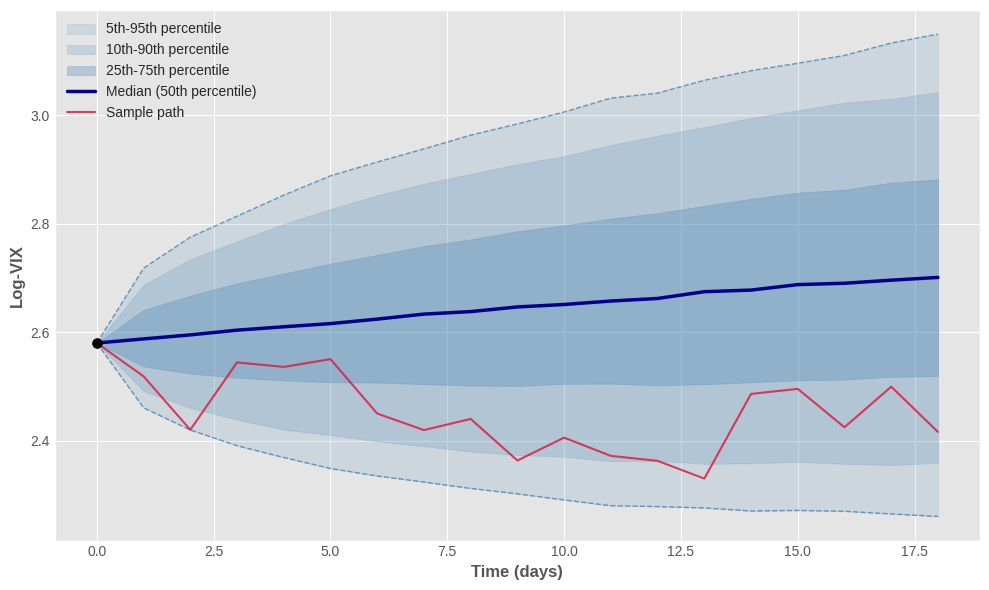

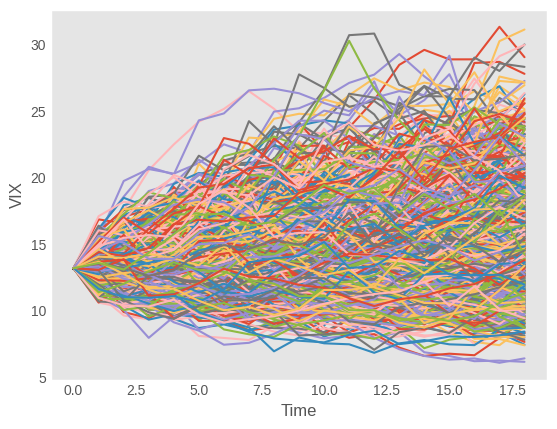

In [ ]:
def simulating_OU(V0, timesteps,Vmean,vol,a,paths):
  dt = 1
  V = np.zeros((paths, timesteps+1))
  V[:,0] = V0
  np.random.seed(42)
  DW = np.random.normal(0,1, size=(paths,timesteps))
  for i in range(timesteps):
    V[:,i+1] = V[:,i] - a*(V[:,i] - Vmean)*dt + vol*np.sqrt(dt)*DW[:,i]
  return V

futurelogvix = simulating_OU(np.log(13.2),18,Vmean,vol,a,10000)

expectedfuturelogvix = np.mean(futurelogvix[:,-1])
std = np.std(futurelogvix[:,-1])

print(np.exp(expectedfuturelogvix))
print(std)

plusstd = expectedfuturelogvix + std
minusstd = expectedfuturelogvix - std

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 18, 19)
upper = np.percentile(futurelogvix, 95, axis=0)
middle = np.percentile(futurelogvix, 50, axis=0)
lower = np.percentile(futurelogvix, 5, axis=0)
p90 = np.percentile(futurelogvix, 90, axis=0)
p75 = np.percentile(futurelogvix, 75, axis=0)
p25 = np.percentile(futurelogvix, 25, axis=0)
p10 = np.percentile(futurelogvix, 10, axis=0)
plt.figure(figsize=(10, 6))
plt.fill_between(t, lower, upper, alpha=0.15, color='steelblue', label='5th-95th percentile')
plt.fill_between(t, p10, p90, alpha=0.2, color='steelblue', label='10th-90th percentile')
plt.fill_between(t, p25, p75, alpha=0.3, color='steelblue', label='25th-75th percentile')
plt.plot(t, middle, color='darkblue', linewidth=2.5, label='Median (50th percentile)')
plt.plot(t, upper, color='steelblue', linewidth=1, alpha=0.8, linestyle='--')
plt.plot(t, lower, color='steelblue', linewidth=1, alpha=0.8, linestyle='--')
plt.plot(t, futurelogvix[1,:], color='crimson', linewidth=1.5, alpha=0.8, label='Sample path')
plt.xlabel('Time (days)', fontsize=12, fontweight='bold')
plt.ylabel('Log-VIX', fontsize=12, fontweight='bold')
plt.legend(loc='upper left', fancybox=True, shadow=True, fontsize=10)
plt.scatter(0, np.log(13.2), color='black', s=50, zorder=5, label='Initial VIX = 13.2')
plt.tight_layout()
plt.show()

for i in range(1000):
  plt.plot(t, np.exp(futurelogvix[i,:]))
plt.xlabel('Time')
plt.ylabel('VIX')
plt.grid()
plt.show()

In [ ]:
print(expectationA)
print(stdA)

2.6978508476770378
0.2648906749444802


In [ ]:
#Setting up quadrature
M=100
Xi0 = expectedfuturelogvix - 9*newvol
XiM = expectedfuturelogvix + 9*newvol
Xi = np.linspace(Xi0,XiM,M)

print(Xi)

#Computing probability density at each datapoint:
probdist = scipy.stats.norm(expectedfuturelogvix,newvol)
probdensities = np.log(probdist.pdf(Xi))
print(np.exp(probdensities))

#For value@risk
percent5value = probdist.ppf(0.05)
print(percent5value)


q_buy = cp.Variable(len(strikes), nonneg=True)
q_sell = cp.Variable(len(strikes), nonneg=True)
q_net = q_buy - q_sell #net position
q_riskfree = cp.Variable()

portfoliocost = cp.sum(cp.multiply(ask_prices, q_buy)) - cp.sum(cp.multiply(bid_prices, q_sell)) + q_riskfree #portfolio cost

def payoff(Xi):
    payoffs = np.zeros(len(strikes))
    for i in range(len(strikes)):
      if option_types[i] == 'C':
        payoffs[i] = np.maximum(np.exp(Xi) - strikes[i], 0)
      if option_types[i] == 'P':
        payoffs[i] = np.maximum(strikes[i] - np.exp(Xi),0)
    return payoffs

def objectivefunction(lamda,w,c):
  f = []
  for i in range(len(Xi)):
    portfolioATmaturity = cp.sum(cp.multiply(q_net, payoff(Xi[i]))) + q_riskfree
    f.append((lamda/w)*(c - portfolioATmaturity))

  delta = np.log((18*newvol)/100)
  quadraturepoints = []
  for i in range(len(Xi)):
    quadraturepoints.append(f[i] + probdensities[i] + delta)
  quadrature = cp.log_sum_exp(cp.hstack(quadraturepoints))
  objectivefunction = (1/lamda)*quadrature
  return objectivefunction

[0.28808 0.33684 0.38561 0.43437 0.48314 0.5319  0.58067 0.62943 0.67819
 0.72696 0.77572 0.82449 0.87325 0.92202 0.97078 1.01955 1.06831 1.11707
 1.16584 1.2146  1.26337 1.31213 1.3609  1.40966 1.45843 1.50719 1.55595
 1.60472 1.65348 1.70225 1.75101 1.79978 1.84854 1.89731 1.94607 1.99483
 2.0436  2.09236 2.14113 2.18989 2.23866 2.28742 2.33618 2.38495 2.43371
 2.48248 2.53124 2.58001 2.62877 2.67754 2.7263  2.77506 2.82383 2.87259
 2.92136 2.97012 3.01889 3.06765 3.11642 3.16518 3.21394 3.26271 3.31147
 3.36024 3.409   3.45777 3.50653 3.5553  3.60406 3.65282 3.70159 3.75035
 3.79912 3.84788 3.89665 3.94541 3.99418 4.04294 4.0917  4.14047 4.18923
 4.238   4.28676 4.33553 4.38429 4.43306 4.48182 4.53058 4.57935 4.62811
 4.67688 4.72564 4.77441 4.82317 4.87194 4.9207  4.96946 5.01823 5.06699
 5.11576]
[0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.00001 0.00001 0.

In [ ]:
def simulating_OU(V0, timesteps,Vmean,vol,a,paths):
  dt = 1
  V = np.zeros((paths, timesteps+1))
  V[:,0] = V0
  np.random.seed(42)
  DW = np.random.normal(0,1, size=(paths,timesteps))
  for i in range(timesteps):
    V[:,i+1] = V[:,i] - a*(V[:,i] - Vmean)*dt + vol*np.sqrt(dt)*DW[:,i]
  return V

maturityvix = simulating_OU(np.log(13.2), 18,Vmean,vol,a,10000)[:,-1]
print(maturityvix)
print(np.mean(maturityvix))
futuresstd = np.std(maturityvix)
maturityvix.shape

[2.55828 2.41623 2.37161 ... 2.67673 2.86921 2.82297]
2.7019180910404392


(10000,)

Optimal portfolio value for lamda = 2: -1.12677
Risk-Free position: -129461.75578773457
Portfolio cost: 99999.99998118302
Number of options traded: 67159.09456143697
Total cost of options 229461.7557689176
Real-world P&L: -10424.986114524741
Percentage winners: 59.9%
Worst loss: -110248.81905287532
Best win: 100878.82117932198
Value at Risk: -11694.440245894251
Expected Shortfall: -12431.18573823445


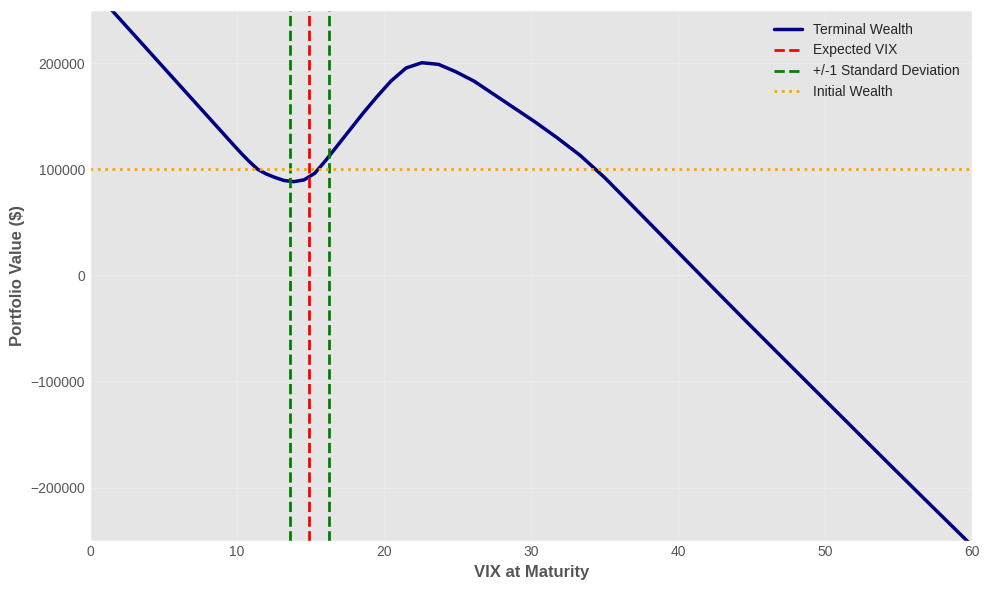

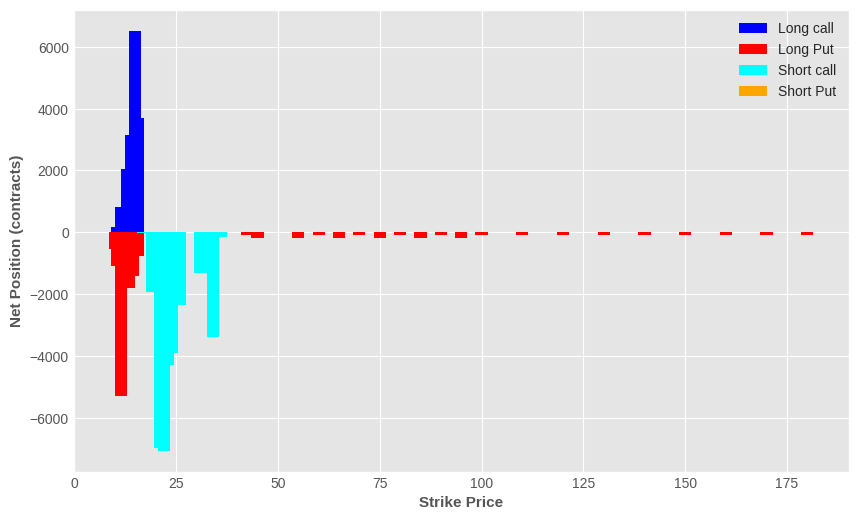

Optimal portfolio value for lamda = 20: -1.02187
Risk-Free position: -77498.4676066988
Portfolio cost: 99999.9992751742
Number of options traded: 17067.51307816073
Total cost of options 177498.466881873
Real-world P&L: 462.57060409066617
Percentage winners: 72.16%
Worst loss: -9306.970301996247
Best win: 38539.28484610026
Value at Risk: -2338.195536082705
Expected Shortfall: -2478.7264296676667


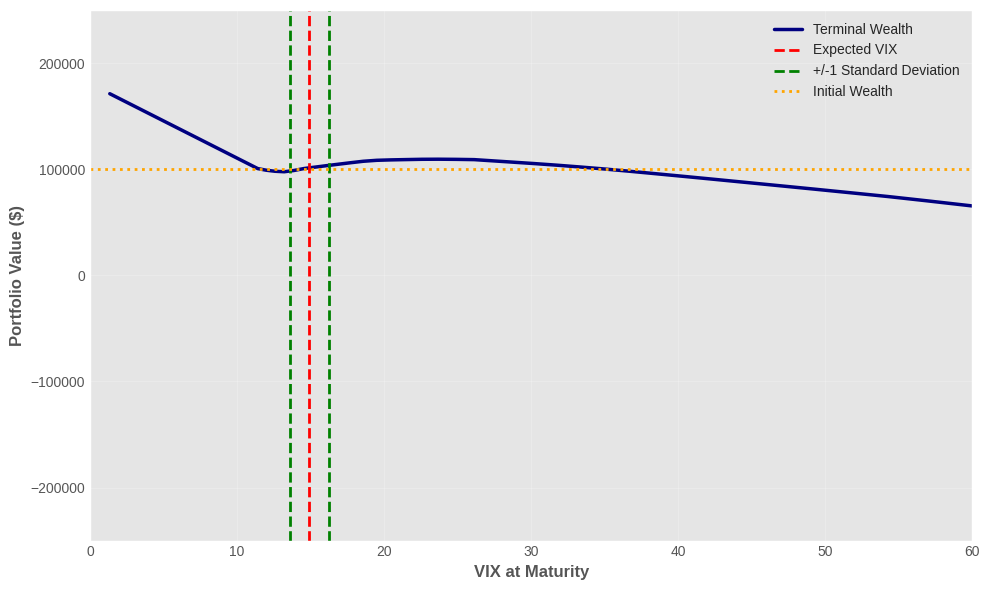

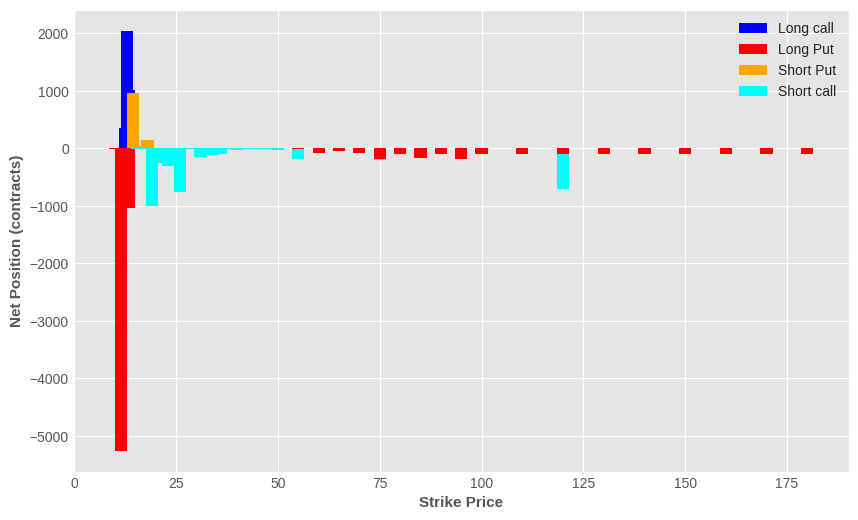

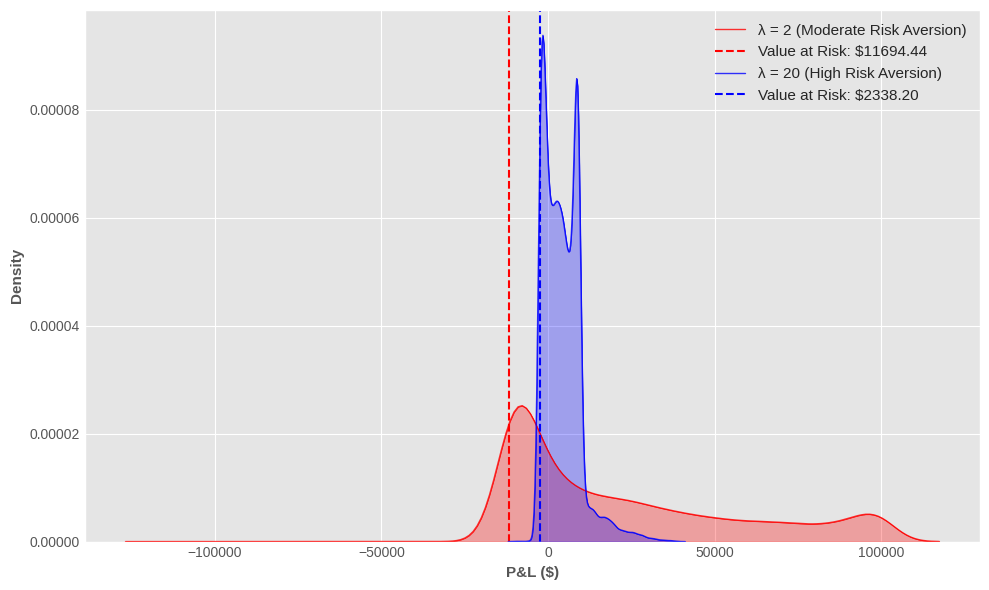

In [ ]:
#Portfolio Optimisation for lamda = 2, 20
def portfoliooptimisation(riskaversion):
  objective1 = cp.Minimize(objectivefunction(riskaversion,100000, 0))

  constraints = [q_buy <= ask_sizes,
                q_sell <= bid_sizes,
                ask_prices @ q_buy - bid_prices @ q_sell + q_riskfree <= 100000]

  prob = cp.Problem(objective1, constraints)
  result_2 = prob.solve(solver = cp.MOSEK)


  if prob.status == cp.OPTIMAL:
    print(f"Optimal portfolio value for lamda = {riskaversion}: {result_2:.5f}")
    print(f'Risk-Free position: {q_riskfree.value}')
    calculatedportfolio_cost = ask_prices @ q_buy.value - bid_prices @ q_sell.value + q_riskfree.value
    print(f'Portfolio cost: {calculatedportfolio_cost}')
    print(f'Number of options traded: {np.sum(np.abs(q_net.value))}')
    print(f'Total cost of options {calculatedportfolio_cost-q_riskfree.value}')

    portfoliovalues = []
    for i in range(len(Xi)):
      portfoliovalues.append((q_net.value @ payoff(Xi[i])) + q_riskfree.value)

    reasonableportfolios = []
    for i in range(len(maturityvix)):
      reasonableportfolios.append((q_net.value @ payoff(maturityvix[i])) + q_riskfree.value - calculatedportfolio_cost)

    realwordpayout = (q_net.value @ payoff(np.log(14.48))) + q_riskfree.value - calculatedportfolio_cost
    print(f'Real-world P&L: {realwordpayout}')

    moneymakers = np.sum(np.array(reasonableportfolios) > 0)
    worstloss = np.min(reasonableportfolios)
    bestwin = np.max(reasonableportfolios)
    print(f'Percentage winners: {100*moneymakers/len(maturityvix)}%')
    print(f'Worst loss: {worstloss}')
    print(f'Best win: {bestwin}')


    Valatrisk = np.percentile(reasonableportfolios, 5)

    shortfalls = []
    for i in range(len(maturityvix)):
      if ((q_net.value @ payoff(maturityvix[i])) + q_riskfree.value -calculatedportfolio_cost)<= Valatrisk:
        shortfalls.append(q_net.value @ payoff(maturityvix[i])-calculatedportfolio_cost + q_riskfree.value)

    expectedshortfall = np.mean(shortfalls)
    print(f'Value at Risk: {Valatrisk}')
    print(f'Expected Shortfall: {expectedshortfall}')

    plt.figure(figsize=(10, 6))
    plt.plot(np.exp(Xi), portfoliovalues, linewidth=2.5, color='navy', label='Terminal Wealth')

    plt.axvline(np.exp(np.mean(maturityvix)), linestyle='--', color='red', label='Expected VIX', linewidth=2)
    plt.axvline(np.exp(np.mean(maturityvix))+np.exp(np.std(maturityvix)), linestyle='--', color='green', label='+/-1 Standard Deviation', linewidth=2)
    plt.axvline(np.exp(np.mean(maturityvix))-np.exp(np.std(maturityvix)), linestyle='--', color='green', linewidth=2)
    plt.axhline(calculatedportfolio_cost, linestyle=':', color='orange', label='Initial Wealth', linewidth=2)

    plt.xlabel('VIX at Maturity', fontsize=12, fontweight='bold')
    plt.ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')

    plt.legend(loc='best', framealpha=0.9, fontsize=10)
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    plt.xlim(0,60)
    plt.ylim(-250000,250000)
    plt.tight_layout()
    plt.show()

    PNL = np.array(portfoliovalues) - 100000
    workingscenarios = np.vstack((np.exp(Xi), PNL)).T
    #print(workingscenarios)

    long_calls = []
    short_calls = []
    long_puts = []
    short_puts = []

    for i in range(len(strikes)):
        if option_types[i] == 'C':
            if q_net.value[i] > 0:
                long_calls.append(abs(q_net.value[i]))
            else:
                short_calls.append(abs(q_net.value[i]))
        elif option_types[i] == 'P':
            if q_net.value[i] > 0:
                long_puts.append(abs(q_net.value[i]))
            else:
                short_puts.append(abs(q_net.value[i]))



    plt.figure(figsize=(10, 6))
    legend_labels = set()

    for i in range(len(strikes)):
        if option_types[i] == 'C':
            if q_net.value[i] > 0:
                label = 'Long call' if 'Long call' not in legend_labels else ""
                plt.bar(strikes[i], q_net.value[i], color='blue', width=3, label=label)
                legend_labels.add('Long call')
            else:
                label = 'Short call' if 'Short call' not in legend_labels else ""
                plt.bar(strikes[i], q_net.value[i], color='cyan', width=3, label=label)
                legend_labels.add('Short call')
        elif option_types[i] == 'P':
            if q_net.value[i] > 0:
                label = 'Long Put' if 'Long Put' not in legend_labels else ""
                plt.bar(strikes[i], -q_net.value[i], color='red', width=3, label=label)
                legend_labels.add('Long Put')
            else:
                label = 'Short Put' if 'Short Put' not in legend_labels else ""
                plt.bar(strikes[i], -q_net.value[i], color='orange', width=3, label=label)
                legend_labels.add('Short Put')

    plt.xlabel('Strike Price', fontsize=11, fontweight='bold')
    plt.ylabel('Net Position (contracts)', fontsize=11, fontweight='bold')
    plt.legend(loc='upper right')
    plt.show()

  else:
    print(f"Problem status: {prob.status}")

  return portfoliovalues, Valatrisk, expectedshortfall, reasonableportfolios

portfoliovalues2, VatRisk2, shortfall2, reasonableportfolios2 = portfoliooptimisation(2)
portfoliovalues20, VatRisk20, shortfall20, reasonableportfolios20 = portfoliooptimisation(20)
#portfoliovalues50, VatRisk50, shortfall50, reasonableportfolios50 = portfoliooptimisation(50)

plt.figure(figsize=(10, 6))
sns.kdeplot(reasonableportfolios2, linewidth=1, label='λ = 2 (Moderate Risk Aversion)', alpha=0.8, color='red')
sns.kdeplot(reasonableportfolios2, alpha=0.3, fill=True, color='red')
plt.axvline(VatRisk2, linestyle='--', color='red', label=f'Value at Risk: ${-VatRisk2:.2f}')
#plt.axvline(shortfall2, linestyle=':', color='red', label=f'Shortfall: ${-shortfall2:.2f}')

sns.kdeplot(reasonableportfolios20, linewidth=1, label='λ = 20 (High Risk Aversion)', alpha=0.8, color='blue')
sns.kdeplot(reasonableportfolios20, alpha=0.3, fill=True, color='blue')
plt.axvline(VatRisk20, linestyle='--', color='blue', label=f'Value at Risk: ${-VatRisk20:.2f}')
#plt.axvline(shortfall20, linestyle=':', color='blue', label=f'Shortfall: ${-shortfall20:.2f}')

#sns.kdeplot(reasonableportfolios50, linewidth=1, label='λ = 50 (Very High Risk Aversion)', alpha=0.8, color='green')
#sns.kdeplot(reasonableportfolios50, alpha=0.3, fill=True, color='green')
#plt.axvline(VatRisk50, linestyle='--', color='green', label=f'Value at Risk: ${-VatRisk50:.2f}')

plt.xlabel('P&L ($)', fontsize=11, fontweight='bold')
plt.ylabel('Density', fontsize=11, fontweight='bold')
plt.ticklabel_format(style='plain')

plt.legend(fontsize=11, loc='upper right', framealpha=0.9)
plt.tight_layout()
plt.show()

# Task 5 and 6

In [ ]:
def digitalpayoffs(Xi):
  payoffs = np.zeros(11)
  digitalstrikes = [5*k for k in range(11)]
  for k in range(len(digitalstrikes)):
    payoffs[k] = 1000 * (np.exp(Xi) > digitalstrikes[k])
  return payoffs

digitaloptionpayouts = []
for i in range(len(Xi)):
  digitaloptionpayouts.append(digitalpayoffs(Xi[i]))
digitaloptionpayouts = np.array(digitaloptionpayouts)

print(digitaloptionpayouts.shape)

def objectivefunction_with_liability_selling(lamda,w, digitaloptionpayouts, c, j):
  f = []
  for i in range(len(Xi)):
    F_position = digitaloptionpayouts[i,j]
    f.append((lamda/w)*(c + F_position))

  delta = np.log((18*newvol)/100)
  quadraturepoints = []
  for i in range(len(Xi)):
    quadraturepoints.append(f[i] + probdensities[i] + delta)
  quadrature = cp.log_sum_exp(cp.hstack(quadraturepoints))
  objective = (1/lamda)*quadrature
  return objective

def objective(lamda, w, c, j):
  f = []
  for i in range(len(Xi)):
    f.append((lamda/w)*(c))

  delta = np.log((18*newvol)/100)
  quadraturepoints = []
  for i in range(len(Xi)):
    quadraturepoints.append(f[i] + probdensities[i] + delta)
  quadrature = cp.log_sum_exp(cp.hstack(quadraturepoints))
  objective = (1/lamda)*quadrature
  return objective


def objectivefunction_with_liability_buying(lamda, w, digitaloptionpayouts, c, j):
  f = []
  for i in range(len(Xi)):
    F_position = digitaloptionpayouts[i,j]
    f.append((lamda/w)*(c - F_position))
  delta = np.log((18*newvol)/100)
  quadraturepoints = []
  for i in range(len(Xi)):
    quadraturepoints.append(f[i] + probdensities[i] + delta)
  quadrature = cp.log_sum_exp(cp.hstack(quadraturepoints))
  objective = (1/lamda)*quadrature
  return objective

def objectivecalculation(riskaversion, initialwealth, c):
  Sobjectives = []
  Bobjectives = []
  Nobjectives = []
  for j in range(11):
    Sobjective = (objectivefunction_with_liability_selling(riskaversion, initialwealth, digitaloptionpayouts, c, j))
    Bobjective = (objectivefunction_with_liability_buying(riskaversion, initialwealth, digitaloptionpayouts, c, j))
    Nobjective = (objective(riskaversion, initialwealth, 0, j))


    Sobjectives.append(Sobjective.value)
    Bobjectives.append(Bobjective.value)
    Nobjectives.append(Nobjective.value)


  return np.array(Sobjectives), np.array(Bobjectives), np.array(Nobjectives)


def indifferencepricing(Sobj2, Sobj20, Bobj2, Bobj20, Nobj2, Nobj20, c, w):

  indifferencesellingprice2 = np.zeros(11)
  indifferencesellingprice20 = np.zeros(11)
  indifferencebuyingprice2 = np.zeros(11)
  indifferencebuyingprice20 = np.zeros(11)

  for i in range(11):
    indifferencesellingprice2[i] = w * ((Sobj2[i])-(Nobj2[i]))
    indifferencesellingprice20[i] = w * ((Sobj20[i])-(Nobj20[i]))

    indifferencebuyingprice2[i] = w * ((Nobj2[i])-(Bobj2[i]))
    indifferencebuyingprice20[i] = w * ((Nobj20[i])-(Bobj20[i]))
  return indifferencesellingprice20, indifferencesellingprice2, indifferencebuyingprice20, indifferencebuyingprice2

(100, 11)


In [ ]:
#Calculations with c = 0

Sobj2, Bobj2, Nobj2 = objectivecalculation(2,100000, 0)
Sobj20, Bobj20, Nobj20 = objectivecalculation(20,100000, 0)

price20s, price2s, price20b, price2b = indifferencepricing(Sobj2, Sobj20, Bobj2, Bobj20, Nobj2, Nobj20, 0, 100000)

print('For Lamda = 20')
print(f'Indifference selling price: {price20s}')
print(f'Indifference buying price: {price20b}')

print('For Lamda = 2')
print(f'Indifference selling price: {price2s}')
print(f'Indifference buying price: {price2b}')

prctdif2 = ((price2s - price2b)/(0.5*(price2b+price2s)))*100
prctdif20 = ((price20s - price20b)/(0.5*(price20b+price20s)))*100

prctdifbuy = ((price2b - price20b)/(0.5*(price20b+price2b)))*100
prctdifsell = ((price2s - price20s)/(0.5*(price20s+price2s)))*100

prctdifbs = ((0.01*prctdifbuy + 0.01*prctdifsell)/(0.5*(0.01*prctdifbuy-0.01*prctdifsell)))*100

For Lamda = 20
Indifference selling price: [1000.       999.97195  933.74425  524.95844  149.7557    24.95782
    5.9767     0.5802     0.1501     0.01561    0.00295]
Indifference buying price: [1000.       999.96575  920.24828  475.04156  126.03954   20.5269
    4.89863    0.47508    0.1229     0.01278    0.00241]
For Lamda = 2
Indifference selling price: [1000.       999.96936  928.04982  502.49996  138.51565   22.82386
    5.45625    0.52942    0.13696    0.01424    0.00269]
Indifference buying price: [1000.       999.96875  926.70286  497.50004  136.14628   22.38203
    5.34879    0.51894    0.13425    0.01396    0.00263]


In [ ]:
print(prctdif2)
print(prctdif20)
print(prctdifbuy)
print(prctdifsell)
print(prctdifbs)

[0.      0.00006 0.14524 0.99998 1.72529 1.95473 1.98913 1.99889 1.99966
 1.9999  1.99993]
[-0.       0.00062  1.45588  9.98338 17.19838 19.48314 19.82592 19.92315
 19.9309  19.93332 19.93355]
[-0.       0.0003   0.69894  4.61851  7.7096   8.64684  8.78576  8.82509
  8.82822  8.8292   8.82929]
[ 0.      -0.00026 -0.61171 -4.37166 -7.79824 -8.93214 -9.10433 -9.15327
 -9.15717 -9.15839 -9.15851]
[-180.95238   14.64151   13.31084    5.49168   -1.14317   -3.24589
   -3.56138   -3.65087   -3.658     -3.66023   -3.66044]


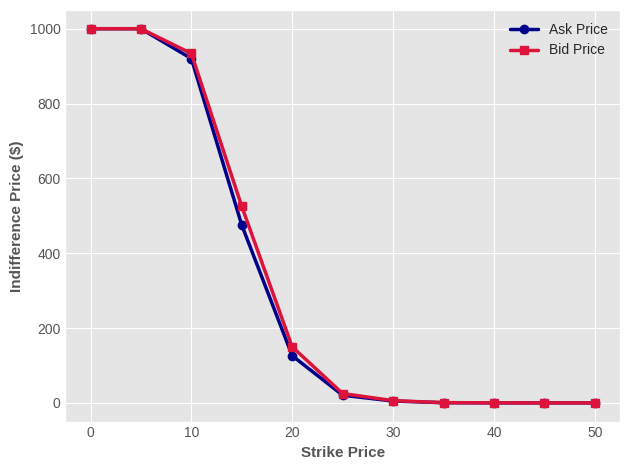

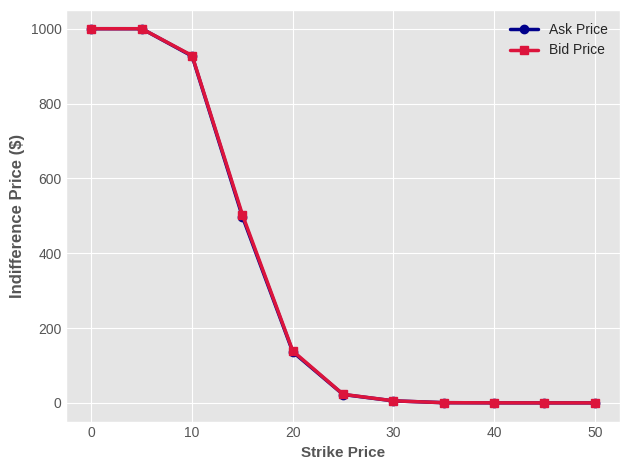

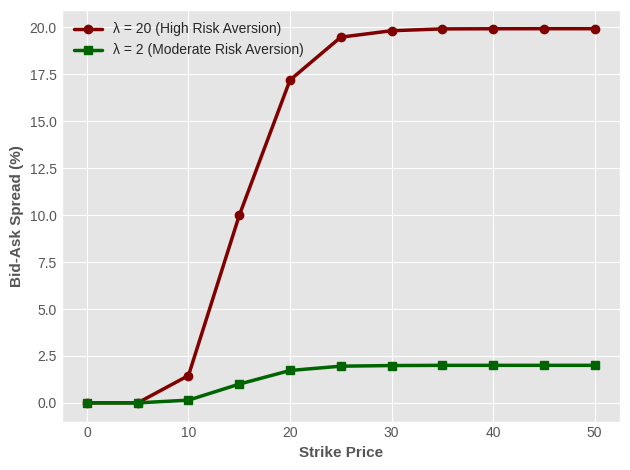

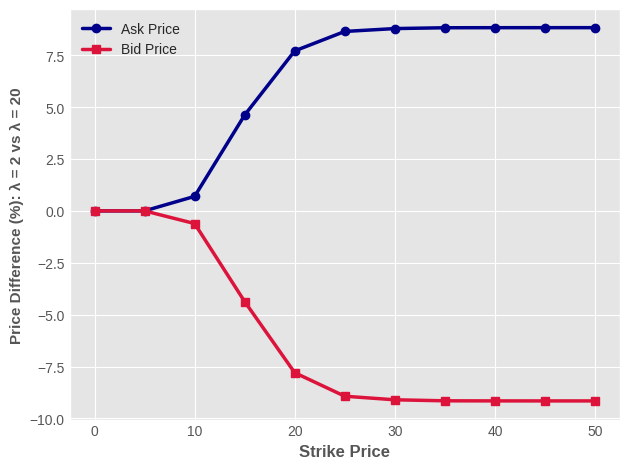

In [ ]:
plt.plot([5*k for k in range(11)], price20b,
         label='Ask Price',
         linewidth=2.5, color='darkblue', marker='o', markersize=6)
plt.plot([5*k for k in range(11)], price20s,
         label='Bid Price',
         linewidth=2.5, color='crimson', marker='s', markersize=6)
plt.xlabel('Strike Price', fontsize=11, fontweight='bold')
plt.ylabel('Indifference Price ($)', fontsize=11, fontweight='bold')
plt.legend(loc='upper right', framealpha=0.9, fontsize=10)
plt.xticks(range(0, 55, 10), fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


plt.plot([5*k for k in range(11)], price2b,
         label='Ask Price',
         linewidth=2.5, color='darkblue', marker='o', markersize=6)
plt.plot([5*k for k in range(11)], price2s,
         label='Bid Price',
         linewidth=2.5, color='crimson', marker='s', markersize=6)
plt.xlabel('Strike Price', fontsize=11, fontweight='bold')
plt.ylabel('Indifference Price ($)', fontsize=12, fontweight='bold')
plt.legend(loc='upper right', framealpha=0.9, fontsize=10)
plt.xticks(range(0, 55, 10), fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

plt.plot([5*k for k in range(11)], prctdif20,
         label='λ = 20 (High Risk Aversion)',
         linewidth=2.5, color='maroon', marker='o', markersize=6)
plt.plot([5*k for k in range(11)], prctdif2,
         label='λ = 2 (Moderate Risk Aversion)',
         linewidth=2.5, color='darkgreen', marker='s', markersize=6)

plt.xlabel('Strike Price', fontsize=11, fontweight='bold')
plt.ylabel('Bid-Ask Spread (%)', fontsize=11, fontweight='bold')
plt.legend(loc='upper left', framealpha=0.9, fontsize=10)
plt.xticks(range(0, 55, 10), fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

plt.plot([5*k for k in range(11)], prctdifbuy,
         label='Ask Price',
         linewidth=2.5, color='darkblue', marker='o', markersize=6)
plt.plot([5*k for k in range(11)], prctdifsell,
         label='Bid Price',
         linewidth=2.5, color='crimson', marker='s', markersize=6)

plt.xlabel('Strike Price', fontsize=12, fontweight='bold')
plt.ylabel('Price Difference (%): λ = 2 vs λ = 20', fontsize=11, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.xticks(range(0, 55, 10), fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()